# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [2]:
# Install requirements
!python -m pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create training set and define training dataloader
train_set = torchvision.datasets.MNIST("./image_data", train=True, download=True, transform=transform)
train_set, valid_set = torch.utils.data.random_split(train_set, [50000, 10000])

trainloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)

# Create test set and define test dataloader
test_set = torchvision.datasets.MNIST("./image_data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=32)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?


I use the `ToTensor()` function first to transform the images to tensor, i.e convert it to the required torch datatype.

Secondly, I used the ``Normalize()`` function to normalize the data for easy processing by the model, this normalizes a tensor image data to be within a specified range suitable for the network to train on.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [14]:
for i in trainloader:
    print("Shape:", i[0].shape)
    print("Size:", i[0].size)
    break

Shape: torch.Size([32, 1, 28, 28])
Size: <built-in method size of Tensor object at 0x000001686B650F48>


In [3]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

8


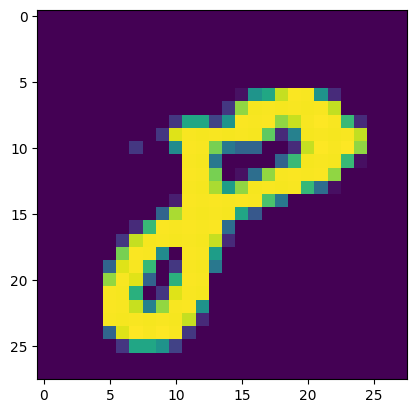

8


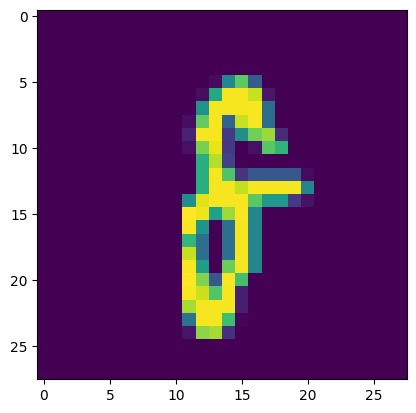

8


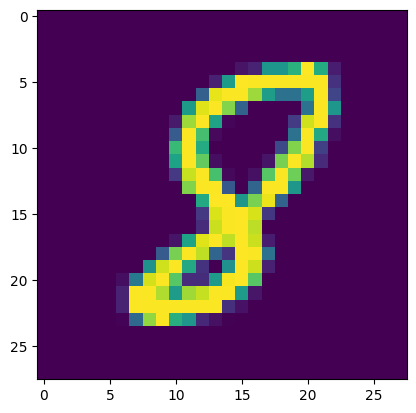

2


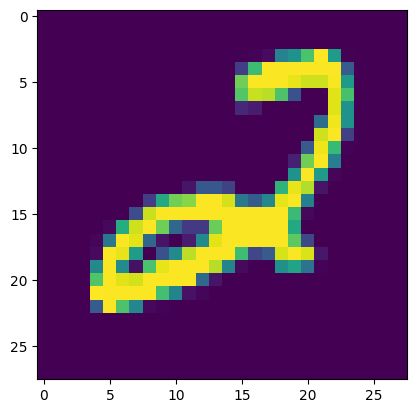

6


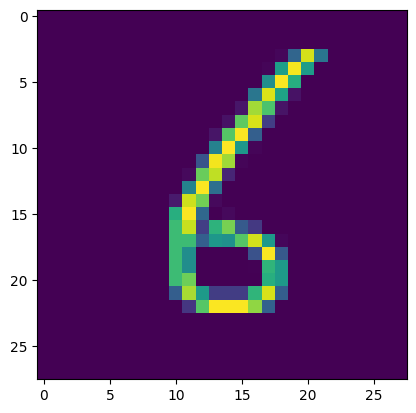

In [4]:
# Explore data
show5(trainloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [10]:

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.dropout = nn.Dropout(p=0.2)
        
        self.input_layer = nn.Linear(784, 512)
        self.hidden1 = nn.Linear(512, 256)
        self.hidden2 = nn.Linear(256, 64)
        self.output_layer = nn.Linear(64, 10)
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        
        x = self.activation(self.input_layer(x))
        x = self.dropout(x)
        x = self.activation(self.hidden1(x))
        x = self.dropout(x)
        x = self.activation(self.hidden2(x))
        x = self.output_layer(x)
        x = F.log_softmax(x, dim=1)
    
        return x

model = Model()
model.to(device)

Model(
  (dropout): Dropout(p=0.2, inplace=False)
  (input_layer): Linear(in_features=784, out_features=512, bias=True)
  (hidden1): Linear(in_features=512, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=10, bias=True)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [11]:

optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.NLLLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [12]:

def train_model(epochs=1):

    train_loss_history = []
    val_loss_history = []
    save_loss = 100
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

            ps = torch.exp(outputs)
            _, preds = ps.topk(1, dim=1)
            train_correct += (preds.flatten() == labels).sum().item()
            
        print(f"Epoch {epoch + 1} training accuracy: {train_correct/len(train_set):.2f} training loss: {train_loss/len(trainloader):.5f}")
        train_loss_history.append(train_loss/len(trainloader))
        
        val_loss = 0.0
        val_correct = 0
        model.eval()
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            ps = torch.exp(outputs)  # log_ps
            _, preds = ps.topk(1, dim=1)
            val_correct += (preds.flatten() == labels).sum().item()
            
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
        print(f"==> Validation accuracy: {val_correct/len(valid_set):.2f} validation loss: {val_loss/len(validloader):.5f}\n")
        val_loss_history.append(val_loss/len(validloader))
        
        loss_val = val_loss/len(validloader)
        if loss_val < save_loss:
            save_loss = loss_val
            stateDict = model.state_dict()
        
    return train_loss_history, val_loss_history, stateDict

In [13]:
train_loss, val_loss, stateDict = train_model(epochs=15)
torch.save(stateDict, 'best_model2.pt')

Epoch 1 training accuracy: 0.88 training loss: 0.38526
==> Validation accuracy: 0.93 validation loss: 0.20476

Epoch 2 training accuracy: 0.94 training loss: 0.20850
==> Validation accuracy: 0.95 validation loss: 0.15432

Epoch 3 training accuracy: 0.95 training loss: 0.17419
==> Validation accuracy: 0.96 validation loss: 0.14099

Epoch 4 training accuracy: 0.96 training loss: 0.14875
==> Validation accuracy: 0.97 validation loss: 0.10881

Epoch 5 training accuracy: 0.96 training loss: 0.13569
==> Validation accuracy: 0.96 validation loss: 0.13932

Epoch 6 training accuracy: 0.96 training loss: 0.12419
==> Validation accuracy: 0.97 validation loss: 0.10624

Epoch 7 training accuracy: 0.96 training loss: 0.11599
==> Validation accuracy: 0.97 validation loss: 0.09082

Epoch 8 training accuracy: 0.97 training loss: 0.10788
==> Validation accuracy: 0.97 validation loss: 0.11730

Epoch 9 training accuracy: 0.97 training loss: 0.10210
==> Validation accuracy: 0.97 validation loss: 0.09466

E

Plot the training loss (and validation loss/accuracy, if recorded).

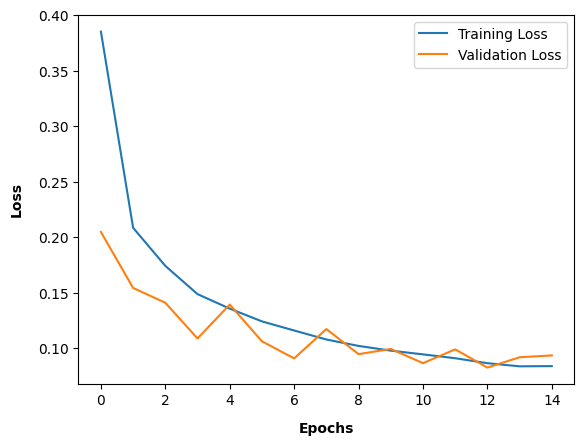

In [15]:

plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs", fontweight='bold', labelpad=10)
plt.ylabel("Loss", fontweight='bold', labelpad=10)

plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [16]:

#testModel = Model()
#testModel.load_state_dict(torch.load('best_model2.pt'))

test_loss = 0.0
test_correct = 0
for inputs, labels in testloader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    test_loss += loss.item()
    
    ps = torch.exp(outputs)
    _, preds = ps.topk(1, dim=1)
    test_correct += (preds.flatten() == labels).sum().item()

print(f"==> Test accuracy: {(test_correct/len(test_set))*100:.2f}% Test loss: {test_loss/len(testloader):.5f}\n")

==> Test accuracy: 97.38% Test loss: 0.08905



# Get the Prediction for a random image.

Run this cell multiple times to test different images.

Real class 4 Predicted class 4


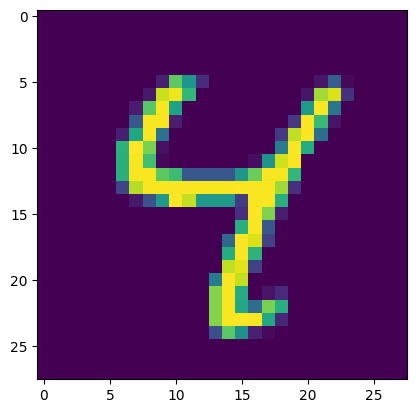

In [22]:
import random


i = random.randint(0, 16)
image, label = next(iter(testloader))

image = image[i]
label = label[i]

output = model(image)
_, pred = torch.exp(output).topk(1, dim=1)

print('Real class', int(label.detach()), 'Predicted class', pred.item())

image = image.numpy()
plt.imshow(image.T.squeeze().T)
plt.show()

## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

## Saving your model
Using `torch.save`, save your model for future loading.

In [18]:
## YOUR CODE HERE ##
filename = "./model.pt"
torch.save(model.state_dict(), filename)